### NB-1: Measure linkage decay as topology changes
Goal: take a sequence of newick trees (organized in a **strange** directory) and, for each tree, determine if a specific bipartition is present.

In [1]:
# pip install strange
# conda install seq-gen -c bioconda
# conda install toytree -c eaton-lab
# #strange includes local raxml-ng 

In [65]:
import numpy as np
import pandas as pd
import strange
import toytree
import toyplot
import seaborn as sns
from matplotlib import pyplot as plt
import os
import ast
from numba import jit
from scipy import stats

In [2]:
assert int(toytree.__version__.split(".")[-1]) >= 19, "update toytree"
print("toytree", toytree.__version__)
print("strange", strange.__version__)

('toytree', '0.1.19')
('strange', '0.2.1-dev')


### Define species trees

In [3]:
imb = toytree.tree("(((((((1,2),3),4),5),6),7),8);").mod.make_ultrametric()
imb5 = imb.mod.node_scale_root_height(5)
imb10 = imb.mod.node_scale_root_height(10)

bal = toytree.tree("(((1,2),(3,4)),((5,6),(7,8)));").mod.make_ultrametric()
bal5 = bal.mod.node_scale_root_height(5)
bal10 = bal.mod.node_scale_root_height(10)

### Plot species trees

In [4]:
trees = toytree.mtree([imb5, imb10, bal5, bal10])
canvas, axes = trees.draw_tree_grid(shared_axis=True, orient='down', height=250, width=700)
axes.y.domain.min = -1

2 1 3 4 5 6 7 8 2 1 3 4 5 6 7 8 8 7 6 5 4 3 2 1 8 7 6 5 4 3 2 1 0.0 2.5 5.0 7.5 10.0

### Generate gene trees on species trees

Simulate a chromosome 1Mbp in length with a mutation rate 10X > than recombination rate. This is the result of the function `Coalseq.simulate()` called by `__init__`. 

To save time, we have set "get_sequences" to **False**

In [5]:
Ne = 250000
mut = 1e-8

In [6]:
kwargs = {
    "workdir": "../tests",
    "mutation_rate": mut,
    "recombination_rate": 1e-9,
    "theta": Ne*mut*4,
    "length": int(1e6), 
    "get_sequences": False,
    "random_seed": 12345,
}

In [7]:
# setup simulation objects
simi5 = strange.Coalseq(tree=imb5, name="imb5", **kwargs)
simi10 = strange.Coalseq(tree=imb10, name="imb10", **kwargs)
simb5 = strange.Coalseq(tree=bal5, name="bal5", **kwargs)
simb10 = strange.Coalseq(tree=bal10, name="bal10", **kwargs)

In [8]:
# number of breakpoints with length >0
simi5.tree_table.shape

(6248, 6)

### The tree table
This is the result of `Coalseq.get_tree_table()` and `Coalseq.get_sequences()`. For each interval the true genealogy is stored as well as `nsnps` in the simulated sequence data. 

In [10]:
simi5.tree_table.head(5)

,end,length,mstree,nsnps,start,treeheight
0,107,107,"(8:2943223.36414657067508,(7:2301312.881055349...",0,0,2943223
1,606,499,"(8:2684972.08116297377273,(7:2301312.881055349...",0,107,2684972
2,675,69,"(8:2684972.08116297377273,(7:2301312.881055349...",0,606,2684972
3,823,148,"(8:2684972.08116297377273,(7:2301312.881055349...",0,675,2684972
4,986,163,"(8:2684972.08116297377273,(7:2301312.881055349...",0,823,2684972


### The clade table
This is the result of `Coalseq.get_clade_table()`. It records for each split in the species tree (referenced by the node idx under the split) whether that split is present in each genealogy interval. 


In [11]:
simi5.clade_table.head(5)

,8,9,10,11,12,13
0,0,0,1,1,1,1
1,0,0,1,1,1,1
2,0,0,1,0,1,1
3,0,1,0,0,1,1
4,0,1,1,0,1,1


How many gene tree topologies exactly match the species tree topology?

In [18]:
counter = 0
# for each mstree...
for i in range(len(simi5.clade_table)):
    # if there are six ones in the row (all species tree clades exist)
    if np.sum(simi5.clade_table.loc[i,:] == 1) == 6:
        # add one to counter if this mstree matches species tree
        counter += 1

# print how many mstrees matches the species tree
print(counter)

459


### Information content of fragments

(we only have nsnps if we run the original code with get_sequences=True)

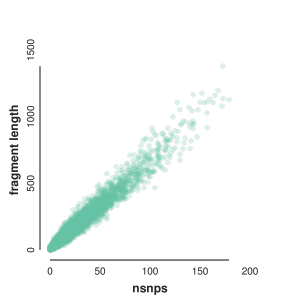

In [11]:
toyplot.config.autoformat = "png"
toyplot.scatterplot(
    simi5.tree_table.nsnps, 
    simi5.tree_table.length,
    width=300, height=300,
    opacity=0.25,
    xlabel='nsnps', ylabel='fragment length',
);

In [12]:
toyplot.config.autoformat = "html"
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(xlabel="fragment length")
axes.bars(
    np.histogram(simi5.tree_table.length),
);

0 500 1000 1500 fragment length 0 1000 2000 3000 4000

### Measure clade support along chromosome

In [20]:
def map_node_colors(ttree):
    ncolors = ttree.get_node_values('idx')
    cidx = 0
    for i in range(len(ncolors)):
        if i in ncolors:
            nidx = ncolors.index(i)
            ncolors[nidx] = toytree.colors[cidx]
            cidx += 1
    return ncolors

In [21]:
def tree_clades_slider_plot(self):
    canvas = toyplot.Canvas(width=500, height=550)
    ax0 = canvas.cartesian(bounds=(75, 425, 50, 250))
    ax1 = canvas.cartesian(bounds=(50, 450, 300, 500), xlabel="Genomic position (Mb)")

    self.tree.draw(
        axes=ax0,
        orient='down', 
        node_sizes=17,
        node_labels=self.tree.get_node_values("idx"),
        node_style={"stroke": "#262626", "fill-opacity": 0.9},
        node_colors=map_node_colors(self.tree),
        tip_labels=False,
    )

    breakpoints = self.tree_table.start
    base = np.zeros(breakpoints.size, dtype=int)
    for col in self.clade_table:
        ax1.fill(
            a=breakpoints,
            b=base, 
            c=base + self.clade_table[col].astype(int), 
            opacity=0.9,
        )
        base += 1

    # styling
    ax0.show = False
    ax1.y.ticks.locator = toyplot.locator.Explicit(
        locations=np.arange(0, 6) + 0.5,
        labels=range(8, 14),
    )
    ax1.x.ticks.locator = toyplot.locator.Explicit(
        locations=np.linspace(0, 1000000, 10),
        labels=range(0, 10),
    )
    ax1.x.ticks.show = True
    ax1.y.ticks.labels.angle = -90
    return canvas, (ax0, ax1)

In [22]:
# for saving figures
import toyplot.svg
import toyplot.pdf

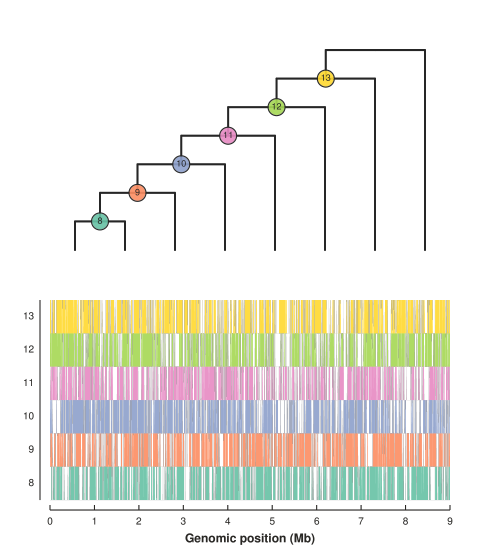

In [23]:
canvas, axes = tree_clades_slider_plot(simi5)
toyplot.html.render(canvas, "../figures/imbalanced_5.html")
toyplot.pdf.render(canvas, "../figures/imbalanced_5.pdf")
canvas

In [24]:
canvas, axes = tree_clades_slider_plot(simb5)
toyplot.html.render(canvas, "../figures/balanced_5.html")
toyplot.pdf.render(canvas, "../figures/balanced_5.pdf")
canvas

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### How large are contiguous clade supporting fragments?

Hmmm, there doesn't seem to be a relationship between the depth of a split and the size of fragments (mean or std) that support the split... I thought there would have been...

In [25]:
def get_clade_lengths(self, cidx):
    lengths = []
    flen = 0
    for idx in self.clade_table.index:
        # extend fragment
        if self.clade_table.loc[idx, cidx] == 1:
            flen += 1
        # terminate fragment
        else:
            if flen:
                lengths.append(flen)
                flen = 0
    return np.array(lengths)

In [26]:
dset = simi5
for node in dset.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(dset, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	13.30	16.99
12	14.85	19.44
11	11.48	13.21
10	14.47	18.68
9	16.75	19.51
8	17.20	19.91


In [27]:
dset = simi10
for node in dset.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(dset, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	29.99	41.84
12	39.82	65.60
11	29.30	40.74
10	26.20	33.36
9	26.94	37.11
8	34.38	44.06


### What if we consider particular subtree topologies (rather than splits)

First, let's make the full clades array -- including all observed clades in mstrees.

In [28]:
simi5.make_cladesarr()

In [30]:
simi5.cladesarr

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int8)

In [32]:
simi5.cladesarr.shape

(6248, 177)

Each row in this array corresponds to a consecutive mstree, and each column corresponds to a particular clade. The specific clade corresponding to an individual column index can be found by querying the **cladeslist**:

In [39]:
simi5.cladeslist[0:10]

array([set(['3', '2']), set(['8', '7']), set(['1', '2']), set(['1', '3']),
       set(['2', '4']), set(['2', '5']), set(['3', '4']), set(['3', '5']),
       set(['3', '6']), set(['1', '5'])], dtype=object)

In [38]:
simi5.cladeslist.shape

(177,)

Now, we can check for the presence of particular clades in an mstree using the **query_clades()** function.

In [40]:
simi5.query_clades([{'1','2'}])

array([False, False, False, ...,  True,  True,  True])

In [48]:
# how many mstrees preserve the {'1','2'} clade?
np.sum(simi5.query_clades([{'1','2'}]))

3789

This returns an array where each index corresponds to an mstree.

Now we can ask (again -- see where we do this in the clades list above) how many mstrees match the species tree:

In [47]:
np.sum(simi5.query_clades([{'1','2'},
                           {'1','2','3'},
                           {'1','2','3','4'},
                           {'1','2','3','4','5'},
                           {'1','2','3','4','5','6'},
                           {'1','2','3','4','5','6','7'}]))

459

What about fragment lengths?

In [49]:
def get_subtree_lengths(pres_arr):
    lengths = []
    flen = 0
    for gt in pres_arr:
        # extend fragment
        if gt == 1:
            flen += 1
        # terminate fragment
        else:
            if flen:
                lengths.append(flen)
                flen = 0
    return np.array(lengths)

In [54]:
# define clades that we'll look for
st_clade_list = [{'1','2'},
{'1','2','3'},
{'1','2','3','4'},
{'1','2','3','4','5'},
{'1','2','3','4','5','6'},
{'1','2','3','4','5','6','7'}]

### "What is the average fragment length for each subtree?"

(in terms of consecutive mstrees, rather than in terms of base pairs...)

going from only including the clade `{'1','2'}` all the way up to matching the whole species tree:

In [58]:
for i in range(len(st_clade_list)):
    # print the average fragment length
    print(np.mean(get_subtree_lengths(simi5.query_clades(st_clade_list[0:i+1]))))

17.2
10.454545454545455
6.236
4.4088669950738915
3.586206896551724
3.1655172413793102


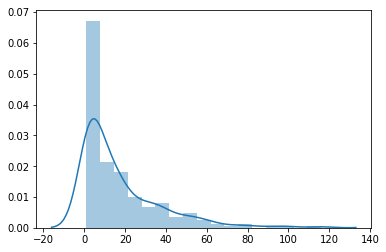

In [63]:
lengths_subtree12 = get_subtree_lengths(simi5.query_clades([{'1','2'}]))
sns.distplot(lengths_subtree12)
plt.show();

### ^looks exponential.

let's fit one and compare.

In [68]:
stats.expon.fit(data=lengths_subtree12)

(0.9999999999412845, 16.200067640844175)

^the second value is the beta parameter (approx. arithmetic mean fragment length)

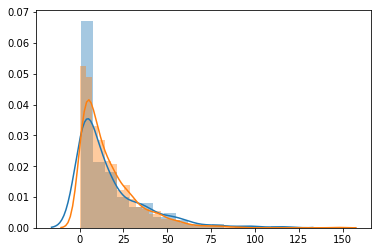

In [72]:
sns.distplot(lengths_subtree12)
sns.distplot(np.random.exponential(stats.expon.fit(data=lengths_subtree12)[1],1000))
plt.show()

fairly good approximation (our data is in blue, data sampled from exponential is in orange). Might improve with sample size.